In [181]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import copy
import matplotlib.pyplot as plt

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [277]:
data = pd.read_csv('Dataset/TC2/train.csv')

In [278]:
data

,velocity_data_x,velocity_data_y,velocity_data_z
0,-0.134012,0.466469,-0.051024
1,-0.202646,0.543844,-0.040844
2,-0.202646,0.543844,-0.040844
3,-0.267686,0.621683,-0.031170
4,-0.299013,0.660611,-0.026600
...,...,...,...
2943,-1.211667,0.883520,-0.000159
2944,-1.211675,0.883522,-0.000159
2945,-1.211683,0.883522,-0.000159
2946,-1.211691,0.883519,-0.000159


In [314]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_max_scaled = data.copy()
columns_to_scale = ['velocity_data_x', 'velocity_data_y', 'velocity_data_z']

scaler = MinMaxScaler()
for column in columns_to_scale:
    df_max_scaled[column] = scaler.fit_transform(np.array(df_max_scaled[column]).reshape(-1, 1) )
    
df_max_scaled

,velocity_data_x,velocity_data_y,velocity_data_z
0,0.987465,0.140303,0.000000
1,0.934934,0.193936,0.117364
2,0.934934,0.193936,0.117364
3,0.885153,0.247892,0.228894
4,0.861175,0.274875,0.281580
...,...,...,...
2943,0.162641,0.429388,0.586414
2944,0.162635,0.429389,0.586414
2945,0.162629,0.429389,0.586414
2946,0.162623,0.429387,0.586414


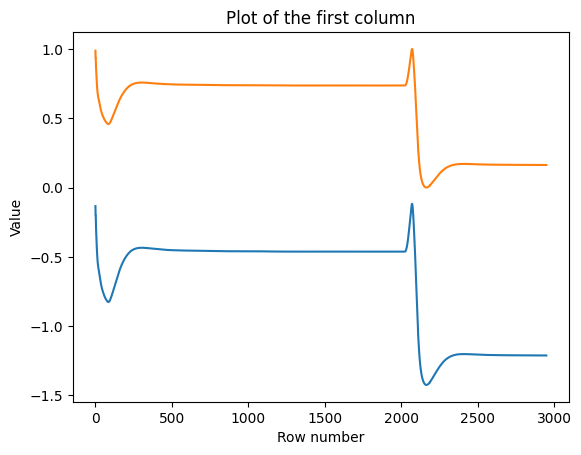

In [315]:
plt.plot(data['velocity_data_x'])
plt.plot(df_max_scaled['velocity_data_x'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

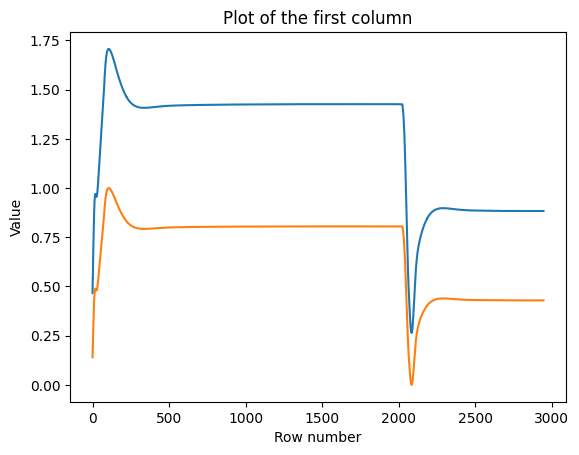

In [316]:
plt.plot(data['velocity_data_y'])
plt.plot(df_max_scaled['velocity_data_y'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

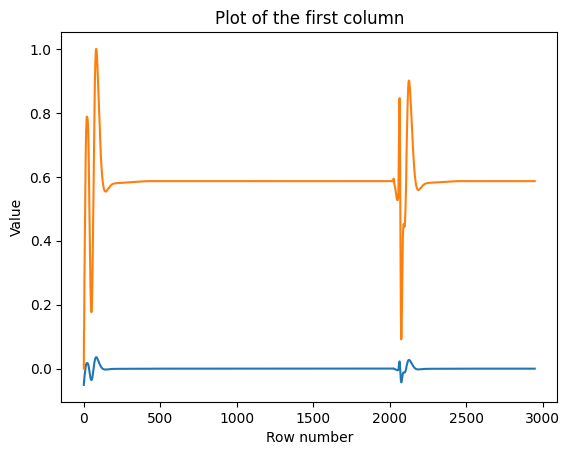

In [317]:
plt.plot(data['velocity_data_z'])
plt.plot(df_max_scaled['velocity_data_z'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

In [318]:
#df_max_scaled.to_csv('df_max_scaled.csv', index=False)

In [319]:
sequence_size = 4
sequences = []

for i in range(len(data) - sequence_size + 1):
    sequence = data.iloc[i:i + sequence_size]
    sequences.append(sequence)

sequences_df = pd.concat(sequences, ignore_index=True)

sequences_df

,velocity_data_x,velocity_data_y,velocity_data_z
0,-0.134012,0.466469,-0.051024
1,-0.202646,0.543844,-0.040844
2,-0.202646,0.543844,-0.040844
3,-0.267686,0.621683,-0.031170
4,-0.202646,0.543844,-0.040844
...,...,...,...
11775,-1.211691,0.883519,-0.000159
11776,-1.211675,0.883522,-0.000159
11777,-1.211683,0.883522,-0.000159
11778,-1.211691,0.883519,-0.000159


In [321]:
x_train = sequences_df.values.tolist()
x_train

[[-0.134012, 0.466469, -0.051024],
 [-0.202646, 0.543844, -0.040844],
 [-0.202646, 0.543844, -0.040844],
 [-0.267686, 0.621683, -0.03117],
 [-0.202646, 0.543844, -0.040844],
 [-0.202646, 0.543844, -0.040844],
 [-0.267686, 0.621683, -0.03117],
 [-0.299013, 0.660611, -0.0266],
 [-0.202646, 0.543844, -0.040844],
 [-0.267686, 0.621683, -0.03117],
 [-0.299013, 0.660611, -0.0266],
 [-0.329513, 0.699309, -0.022177],
 [-0.267686, 0.621683, -0.03117],
 [-0.299013, 0.660611, -0.0266],
 [-0.329513, 0.699309, -0.022177],
 [-0.359074, 0.737451, -0.0179],
 [-0.299013, 0.660611, -0.0266],
 [-0.329513, 0.699309, -0.022177],
 [-0.359074, 0.737451, -0.0179],
 [-0.387509, 0.774519, -0.013663],
 [-0.329513, 0.699309, -0.022177],
 [-0.359074, 0.737451, -0.0179],
 [-0.387509, 0.774519, -0.013663],
 [-0.414533, 0.809782, -0.009355],
 [-0.359074, 0.737451, -0.0179],
 [-0.387509, 0.774519, -0.013663],
 [-0.414533, 0.809782, -0.009355],
 [-0.439797, 0.842406, -0.005043],
 [-0.387509, 0.774519, -0.013663],
 [-0.

In [322]:
class EarlyStopping:
    def __init__(self, patience=20, monitor='val_loss', mode='min', min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif (self.mode == 'min' and self.best_loss - val_loss >= self.min_delta) or \
             (self.mode == 'max' and val_loss - self.best_loss >= self.min_delta):
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
            return False



In [334]:
es = EarlyStopping(patience=20, monitor='val_loss', mode='min', min_delta=1e-5, restore_best_weights=True)

In [335]:
input_size = 3
output_size_forward= (1,3)
output_size_backward = (1,3)
dropout = 0.1
num_layers=1
hidden_size=64
num_epochs=100
learning_rate=0.01
num_steps=1

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Determine device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bias=True, batch_first=True, dropout=dropout, bidirectional=True).to(self.device)  # Move LSTM to device
        self.fc_1 = nn.Linear(hidden_size * 2, 128).to(self.device)  # Move Linear layers to device
        self.relu1 = nn.ReLU()
        self.fc_2 = nn.Linear(128, input_size).to(self.device)
        self._init_weights()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(self.device)  # Move initial states to device
        c0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(self.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc_1(out)
        out = self.relu1(out)
        out = self.fc_2(out)

        return out

    def _init_weights(self):
        for layer in [self.lstm, self.fc_1, self.fc_2]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.LSTM):
                for name, param in layer.named_parameters():
                    if 'weight_ih' in name or 'weight_hh' in name:
                        nn.init.kaiming_normal_(param.data, nonlinearity='relu')
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)


In [336]:
model = Model(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\Archi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [337]:
model.to(device)
model.train()

Model(
  (lstm): LSTM(3, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (relu1): ReLU()
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
)

In [338]:
predicted_vectors = []

last_index = len(x_train) - 4
num_sequences = last_index // 4

for epoch in range(num_epochs):
    predicted_vectors.clear()
    total_loss = 0
    
    for idx in range(0, last_index, 4):
        sequence = torch.tensor(x_train[idx: idx + 4]).to(device)  
        optimizer.zero_grad()

        out_forward = model(sequence)
        predicted_next_element_1 = out_forward[-1, :].view(-1, 3)
        target_next_element = torch.tensor(x_train[idx + 7]).view(-1, 3).to(device)

        loss_forward_1 = criterion(predicted_next_element_1, target_next_element)
        total_loss += loss_forward_1.item()
        
        loss_forward_1.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Sequence {idx // 4 + 1}/{num_sequences}, Loss: {loss_forward_1.item()}")

        predicted_vectors.append(predicted_next_element_1.detach().cpu().numpy())

    # Calculate average loss for the epoch
    avg_loss = total_loss / num_sequences

    # Check for early stopping
    if es(model, avg_loss):
        print("Early stopping triggered.")
        break


Epoch 1/100, Sequence 1/2944, Loss: 0.21763835847377777
Epoch 1/100, Sequence 26/2944, Loss: 0.0005111712962388992
Epoch 1/100, Sequence 51/2944, Loss: 5.861097451997921e-05
Epoch 1/100, Sequence 76/2944, Loss: 1.5904512110864744e-05
Epoch 1/100, Sequence 101/2944, Loss: 5.86984333494911e-06
Epoch 1/100, Sequence 126/2944, Loss: 1.1976206906183506e-06
Epoch 1/100, Sequence 151/2944, Loss: 2.1399346223915927e-06
Epoch 1/100, Sequence 176/2944, Loss: 1.0981968046053225e-07
Epoch 1/100, Sequence 201/2944, Loss: 1.149249087006865e-07
Epoch 1/100, Sequence 226/2944, Loss: 1.2435893950168975e-06
Epoch 1/100, Sequence 251/2944, Loss: 1.6447065931401994e-08
Epoch 1/100, Sequence 276/2944, Loss: 2.632849271932969e-09
Epoch 1/100, Sequence 301/2944, Loss: 2.0976784198545317e-10
Epoch 1/100, Sequence 326/2944, Loss: 3.6686320648016135e-10
Epoch 1/100, Sequence 351/2944, Loss: 9.842734266518605e-11
Epoch 1/100, Sequence 376/2944, Loss: 7.588971229210983e-09
Epoch 1/100, Sequence 401/2944, Loss: 4.

Epoch 2/100, Sequence 451/2944, Loss: 3.237441870140856e-09
Epoch 2/100, Sequence 476/2944, Loss: 8.64718227577832e-11
Epoch 2/100, Sequence 501/2944, Loss: 2.915016145133009e-11
Epoch 2/100, Sequence 526/2944, Loss: 4.507301649969708e-12
Epoch 2/100, Sequence 551/2944, Loss: 3.115614016779844e-11
Epoch 2/100, Sequence 576/2944, Loss: 1.8949564140058328e-11
Epoch 2/100, Sequence 601/2944, Loss: 2.8501203133690645e-12
Epoch 2/100, Sequence 626/2944, Loss: 4.8589125778431e-11
Epoch 2/100, Sequence 651/2944, Loss: 7.9111326864445e-12
Epoch 2/100, Sequence 676/2944, Loss: 9.849932284741736e-13
Epoch 2/100, Sequence 701/2944, Loss: 1.2016838912831673e-11
Epoch 2/100, Sequence 726/2944, Loss: 5.524674034224075e-12
Epoch 2/100, Sequence 751/2944, Loss: 9.587349360587472e-13
Epoch 2/100, Sequence 776/2944, Loss: 3.241180240864949e-11
Epoch 2/100, Sequence 801/2944, Loss: 3.6378049010632463e-12
Epoch 2/100, Sequence 826/2944, Loss: 2.934135139714966e-12
Epoch 2/100, Sequence 851/2944, Loss: 8.0

Epoch 3/100, Sequence 876/2944, Loss: 5.427409389968663e-12
Epoch 3/100, Sequence 901/2944, Loss: 1.633684940799407e-12
Epoch 3/100, Sequence 926/2944, Loss: 9.855608083114697e-13
Epoch 3/100, Sequence 951/2944, Loss: 1.1424671972348754e-12
Epoch 3/100, Sequence 976/2944, Loss: 8.681663786307137e-13
Epoch 3/100, Sequence 1001/2944, Loss: 2.8561016399142325e-12
Epoch 3/100, Sequence 1026/2944, Loss: 7.185079354404822e-13
Epoch 3/100, Sequence 1051/2944, Loss: 2.2526390475174907e-12
Epoch 3/100, Sequence 1076/2944, Loss: 1.3667382113211057e-13
Epoch 3/100, Sequence 1101/2944, Loss: 2.028879841908804e-11
Epoch 3/100, Sequence 1126/2944, Loss: 8.736875155637702e-13
Epoch 3/100, Sequence 1151/2944, Loss: 8.3184045589213e-13
Epoch 3/100, Sequence 1176/2944, Loss: 2.182987644816503e-11
Epoch 3/100, Sequence 1201/2944, Loss: 2.1721155690074267e-12
Epoch 3/100, Sequence 1226/2944, Loss: 1.0909029755923338e-12
Epoch 3/100, Sequence 1251/2944, Loss: 4.504857424592057e-12
Epoch 3/100, Sequence 127

Epoch 4/100, Sequence 1301/2944, Loss: 4.5566449918821306e-11
Epoch 4/100, Sequence 1326/2944, Loss: 9.008553451816947e-12
Epoch 4/100, Sequence 1351/2944, Loss: 1.5080506288178697e-11
Epoch 4/100, Sequence 1376/2944, Loss: 1.5210447484870215e-11
Epoch 4/100, Sequence 1401/2944, Loss: 9.561431507654206e-12
Epoch 4/100, Sequence 1426/2944, Loss: 1.6485375564645466e-11
Epoch 4/100, Sequence 1451/2944, Loss: 1.7717016005322495e-12
Epoch 4/100, Sequence 1476/2944, Loss: 3.2337802140930405e-12
Epoch 4/100, Sequence 1501/2944, Loss: 1.4077585451521824e-11
Epoch 4/100, Sequence 1526/2944, Loss: 7.426280076994196e-12
Epoch 4/100, Sequence 1551/2944, Loss: 4.882265078332004e-11
Epoch 4/100, Sequence 1576/2944, Loss: 2.088265498023656e-11
Epoch 4/100, Sequence 1601/2944, Loss: 4.5143090654509166e-12
Epoch 4/100, Sequence 1626/2944, Loss: 3.5354122407404986e-11
Epoch 4/100, Sequence 1651/2944, Loss: 4.80588051993136e-12
Epoch 4/100, Sequence 1676/2944, Loss: 1.0783006432202313e-11
Epoch 4/100, Se

Epoch 5/100, Sequence 1726/2944, Loss: 1.0033511348150892e-11
Epoch 5/100, Sequence 1751/2944, Loss: 3.138265688984454e-12
Epoch 5/100, Sequence 1776/2944, Loss: 1.8605772304780555e-12
Epoch 5/100, Sequence 1801/2944, Loss: 1.3333150555849826e-11
Epoch 5/100, Sequence 1826/2944, Loss: 1.3306350379188592e-12
Epoch 5/100, Sequence 1851/2944, Loss: 3.727742073356133e-12
Epoch 5/100, Sequence 1876/2944, Loss: 9.010227980388308e-11
Epoch 5/100, Sequence 1901/2944, Loss: 1.99037791456802e-12
Epoch 5/100, Sequence 1926/2944, Loss: 5.748967111824516e-14
Epoch 5/100, Sequence 1951/2944, Loss: 1.643132158113403e-11
Epoch 5/100, Sequence 1976/2944, Loss: 2.5100501104685646e-12
Epoch 5/100, Sequence 2001/2944, Loss: 1.7905428658857026e-12
Epoch 5/100, Sequence 2026/2944, Loss: 1.3648617596118129e-06
Epoch 5/100, Sequence 2051/2944, Loss: 3.9666471707278106e-07
Epoch 5/100, Sequence 2076/2944, Loss: 0.00029141418053768575
Epoch 5/100, Sequence 2101/2944, Loss: 6.886980554554611e-05
Epoch 5/100, Seq

Epoch 6/100, Sequence 2151/2944, Loss: 6.189016403368441e-06
Epoch 6/100, Sequence 2176/2944, Loss: 4.040500698465621e-07
Epoch 6/100, Sequence 2201/2944, Loss: 3.06349562606556e-07
Epoch 6/100, Sequence 2226/2944, Loss: 1.8830451864459974e-08
Epoch 6/100, Sequence 2251/2944, Loss: 3.978534834914171e-09
Epoch 6/100, Sequence 2276/2944, Loss: 1.071524593498907e-07
Epoch 6/100, Sequence 2301/2944, Loss: 4.3708973862521816e-07
Epoch 6/100, Sequence 2326/2944, Loss: 3.761395195311934e-09
Epoch 6/100, Sequence 2351/2944, Loss: 7.943020818856894e-08
Epoch 6/100, Sequence 2376/2944, Loss: 5.45732259382703e-09
Epoch 6/100, Sequence 2401/2944, Loss: 3.5514913232503886e-10
Epoch 6/100, Sequence 2426/2944, Loss: 4.1809544715221136e-10
Epoch 6/100, Sequence 2451/2944, Loss: 1.3770397322421246e-10
Epoch 6/100, Sequence 2476/2944, Loss: 1.362445052610628e-11
Epoch 6/100, Sequence 2501/2944, Loss: 1.3655468755757738e-08
Epoch 6/100, Sequence 2526/2944, Loss: 9.711811355117561e-10
Epoch 6/100, Sequenc

Epoch 7/100, Sequence 2576/2944, Loss: 2.0721636212472916e-11
Epoch 7/100, Sequence 2601/2944, Loss: 9.260871930427683e-11
Epoch 7/100, Sequence 2626/2944, Loss: 4.12584376385805e-12
Epoch 7/100, Sequence 2651/2944, Loss: 6.219660897421875e-11
Epoch 7/100, Sequence 2676/2944, Loss: 3.919248925399188e-09
Epoch 7/100, Sequence 2701/2944, Loss: 5.436979200190706e-10
Epoch 7/100, Sequence 2726/2944, Loss: 1.1749854561537987e-11
Epoch 7/100, Sequence 2751/2944, Loss: 1.0761995461461282e-10
Epoch 7/100, Sequence 2776/2944, Loss: 1.6724219231711857e-11
Epoch 7/100, Sequence 2801/2944, Loss: 4.377812695688377e-11
Epoch 7/100, Sequence 2826/2944, Loss: 3.919135571628374e-10
Epoch 7/100, Sequence 2851/2944, Loss: 9.306418483068235e-12
Epoch 7/100, Sequence 2876/2944, Loss: 4.0616641994173364e-11
Epoch 7/100, Sequence 2901/2944, Loss: 1.1731524085512035e-10
Epoch 7/100, Sequence 2926/2944, Loss: 6.160902950996805e-12
Epoch 8/100, Sequence 1/2944, Loss: 0.02091953158378601
Epoch 8/100, Sequence 26

Epoch 9/100, Sequence 51/2944, Loss: 3.46512024407275e-05
Epoch 9/100, Sequence 76/2944, Loss: 8.09769262559712e-05
Epoch 9/100, Sequence 101/2944, Loss: 1.4824095160292927e-06
Epoch 9/100, Sequence 126/2944, Loss: 1.8089085074279865e-07
Epoch 9/100, Sequence 151/2944, Loss: 1.047624391503632e-05
Epoch 9/100, Sequence 176/2944, Loss: 7.929685352792148e-08
Epoch 9/100, Sequence 201/2944, Loss: 1.2038981367368251e-08
Epoch 9/100, Sequence 226/2944, Loss: 9.443800186303974e-10
Epoch 9/100, Sequence 251/2944, Loss: 4.755797178290777e-08
Epoch 9/100, Sequence 276/2944, Loss: 2.4957766964206485e-09
Epoch 9/100, Sequence 301/2944, Loss: 1.3138079513197454e-10
Epoch 9/100, Sequence 326/2944, Loss: 1.8775248022961932e-10
Epoch 9/100, Sequence 351/2944, Loss: 1.7376544647618175e-10
Epoch 9/100, Sequence 376/2944, Loss: 1.933424442768228e-08
Epoch 9/100, Sequence 401/2944, Loss: 1.1535832289411019e-09
Epoch 9/100, Sequence 426/2944, Loss: 1.160141149814109e-10
Epoch 9/100, Sequence 451/2944, Loss

Epoch 10/100, Sequence 476/2944, Loss: 3.0904556691524476e-10
Epoch 10/100, Sequence 501/2944, Loss: 4.047237545101723e-11
Epoch 10/100, Sequence 526/2944, Loss: 1.9345787125035763e-11
Epoch 10/100, Sequence 551/2944, Loss: 1.311026287531547e-10
Epoch 10/100, Sequence 576/2944, Loss: 6.125835082249065e-12
Epoch 10/100, Sequence 601/2944, Loss: 2.0165366772240123e-12
Epoch 10/100, Sequence 626/2944, Loss: 9.429652891856932e-11
Epoch 10/100, Sequence 651/2944, Loss: 2.6139285180803995e-11
Epoch 10/100, Sequence 676/2944, Loss: 2.7880271875890816e-12
Epoch 10/100, Sequence 701/2944, Loss: 4.865505784726332e-13
Epoch 10/100, Sequence 726/2944, Loss: 4.807904291706522e-13
Epoch 10/100, Sequence 751/2944, Loss: 3.995254647948254e-13
Epoch 10/100, Sequence 776/2944, Loss: 9.935274825068063e-11
Epoch 10/100, Sequence 801/2944, Loss: 9.647584814365118e-12
Epoch 10/100, Sequence 826/2944, Loss: 5.850005375951373e-12
Epoch 10/100, Sequence 851/2944, Loss: 1.2007730920693405e-10
Epoch 10/100, Sequ

Epoch 11/100, Sequence 901/2944, Loss: 4.357425011092264e-12
Epoch 11/100, Sequence 926/2944, Loss: 3.2997571146851923e-13
Epoch 11/100, Sequence 951/2944, Loss: 1.352081207411926e-12
Epoch 11/100, Sequence 976/2944, Loss: 2.7482577845405753e-12
Epoch 11/100, Sequence 1001/2944, Loss: 5.364057044680501e-14
Epoch 11/100, Sequence 1026/2944, Loss: 2.4738045813210707e-12
Epoch 11/100, Sequence 1051/2944, Loss: 1.5395716385785407e-12
Epoch 11/100, Sequence 1076/2944, Loss: 2.9289858299169635e-12
Epoch 11/100, Sequence 1101/2944, Loss: 1.2583366640339655e-11
Epoch 11/100, Sequence 1126/2944, Loss: 1.4338096682164903e-13
Epoch 11/100, Sequence 1151/2944, Loss: 1.0835691068369901e-12
Epoch 11/100, Sequence 1176/2944, Loss: 5.4244619213106304e-11
Epoch 11/100, Sequence 1201/2944, Loss: 4.730646863820853e-12
Epoch 11/100, Sequence 1226/2944, Loss: 2.11277935251164e-12
Epoch 11/100, Sequence 1251/2944, Loss: 2.0400629970052098e-12
Epoch 11/100, Sequence 1276/2944, Loss: 2.8646919905672696e-12
Ep

Epoch 12/100, Sequence 1326/2944, Loss: 9.955798338512345e-12
Epoch 12/100, Sequence 1351/2944, Loss: 1.6824782669497274e-12
Epoch 12/100, Sequence 1376/2944, Loss: 1.84774331252191e-12
Epoch 12/100, Sequence 1401/2944, Loss: 6.729213540557222e-12
Epoch 12/100, Sequence 1426/2944, Loss: 1.8686757002894794e-11
Epoch 12/100, Sequence 1451/2944, Loss: 2.454200037638188e-12
Epoch 12/100, Sequence 1476/2944, Loss: 1.6173752875187075e-12
Epoch 12/100, Sequence 1501/2944, Loss: 1.8658820148675925e-12
Epoch 12/100, Sequence 1526/2944, Loss: 1.3130451587128888e-12
Epoch 12/100, Sequence 1551/2944, Loss: 1.0787888594585016e-12
Epoch 12/100, Sequence 1576/2944, Loss: 3.326740966036468e-11
Epoch 12/100, Sequence 1601/2944, Loss: 4.722425141906461e-12
Epoch 12/100, Sequence 1626/2944, Loss: 7.594784176556679e-13
Epoch 12/100, Sequence 1651/2944, Loss: 1.2648888880750775e-11
Epoch 12/100, Sequence 1676/2944, Loss: 1.148262041006376e-12
Epoch 12/100, Sequence 1701/2944, Loss: 1.7539283556338575e-13
E

Epoch 13/100, Sequence 1751/2944, Loss: 5.214651627172273e-12
Epoch 13/100, Sequence 1776/2944, Loss: 8.272322063462845e-12
Epoch 13/100, Sequence 1801/2944, Loss: 4.4452632547153925e-11
Epoch 13/100, Sequence 1826/2944, Loss: 1.523895939992137e-11
Epoch 13/100, Sequence 1851/2944, Loss: 6.799704462684408e-12
Epoch 13/100, Sequence 1876/2944, Loss: 2.8950503105917846e-10
Epoch 13/100, Sequence 1901/2944, Loss: 2.7457276036146894e-11
Epoch 13/100, Sequence 1926/2944, Loss: 1.0743286685613307e-12
Epoch 13/100, Sequence 1951/2944, Loss: 1.957273648711677e-10
Epoch 13/100, Sequence 1976/2944, Loss: 1.4544548725126116e-11
Epoch 13/100, Sequence 2001/2944, Loss: 1.1033221211653732e-11
Epoch 13/100, Sequence 2026/2944, Loss: 3.960511492095975e-07
Epoch 13/100, Sequence 2051/2944, Loss: 0.00021159804600756615
Epoch 13/100, Sequence 2076/2944, Loss: 4.423048085300252e-05
Epoch 13/100, Sequence 2101/2944, Loss: 1.1117094800283667e-05
Epoch 13/100, Sequence 2126/2944, Loss: 6.257763016037643e-05


Epoch 14/100, Sequence 2176/2944, Loss: 9.782314691619831e-07
Epoch 14/100, Sequence 2201/2944, Loss: 1.4057052055704844e-07
Epoch 14/100, Sequence 2226/2944, Loss: 2.8348176783765666e-07
Epoch 14/100, Sequence 2251/2944, Loss: 9.59571178071883e-09
Epoch 14/100, Sequence 2276/2944, Loss: 4.4346151639729214e-07
Epoch 14/100, Sequence 2301/2944, Loss: 7.749349606456235e-09
Epoch 14/100, Sequence 2326/2944, Loss: 4.583555757164959e-09
Epoch 14/100, Sequence 2351/2944, Loss: 6.781297656743845e-08
Epoch 14/100, Sequence 2376/2944, Loss: 2.048061720216765e-09
Epoch 14/100, Sequence 2401/2944, Loss: 9.655470867286908e-12
Epoch 14/100, Sequence 2426/2944, Loss: 3.8227990217798435e-11
Epoch 14/100, Sequence 2451/2944, Loss: 2.021950662456362e-11
Epoch 14/100, Sequence 2476/2944, Loss: 6.613610700756389e-12
Epoch 14/100, Sequence 2501/2944, Loss: 5.838113326106509e-10
Epoch 14/100, Sequence 2526/2944, Loss: 5.962154658867291e-10
Epoch 14/100, Sequence 2551/2944, Loss: 4.5272324084022486e-11
Epoc

Epoch 15/100, Sequence 2601/2944, Loss: 8.749661585538693e-12
Epoch 15/100, Sequence 2626/2944, Loss: 4.10253862132004e-12
Epoch 15/100, Sequence 2651/2944, Loss: 6.976047343953962e-13
Epoch 15/100, Sequence 2676/2944, Loss: 1.0292202853867671e-11
Epoch 15/100, Sequence 2701/2944, Loss: 2.0781705349637303e-12
Epoch 15/100, Sequence 2726/2944, Loss: 4.569819522792784e-11
Epoch 15/100, Sequence 2751/2944, Loss: 1.4137402186420456e-12
Epoch 15/100, Sequence 2776/2944, Loss: 5.124620888231901e-13
Epoch 15/100, Sequence 2801/2944, Loss: 3.0802814725977568e-12
Epoch 15/100, Sequence 2826/2944, Loss: 1.982367048292133e-11
Epoch 15/100, Sequence 2851/2944, Loss: 4.0046585839115245e-12
Epoch 15/100, Sequence 2876/2944, Loss: 1.5359484517585287e-12
Epoch 15/100, Sequence 2901/2944, Loss: 1.2893731221597093e-12
Epoch 15/100, Sequence 2926/2944, Loss: 3.07984947224213e-13
Epoch 16/100, Sequence 1/2944, Loss: 0.022899217903614044
Epoch 16/100, Sequence 26/2944, Loss: 0.0006671082228422165
Epoch 16/

Epoch 17/100, Sequence 76/2944, Loss: 0.00018385988369118422
Epoch 17/100, Sequence 101/2944, Loss: 1.8981923858518712e-05
Epoch 17/100, Sequence 126/2944, Loss: 2.5277631721110083e-06
Epoch 17/100, Sequence 151/2944, Loss: 4.062085736222798e-06
Epoch 17/100, Sequence 176/2944, Loss: 2.163768897389673e-07
Epoch 17/100, Sequence 201/2944, Loss: 5.923173063138165e-08
Epoch 17/100, Sequence 226/2944, Loss: 2.147795896689786e-08
Epoch 17/100, Sequence 251/2944, Loss: 1.0133248906640802e-08
Epoch 17/100, Sequence 276/2944, Loss: 4.6267727427107275e-09
Epoch 17/100, Sequence 301/2944, Loss: 3.018885363914592e-09
Epoch 17/100, Sequence 326/2944, Loss: 1.8215627894946351e-09
Epoch 17/100, Sequence 351/2944, Loss: 1.4505008305576439e-09
Epoch 17/100, Sequence 376/2944, Loss: 9.20442211338468e-09
Epoch 17/100, Sequence 401/2944, Loss: 1.5241580220148876e-09
Epoch 17/100, Sequence 426/2944, Loss: 5.643193690119119e-10
Epoch 17/100, Sequence 451/2944, Loss: 3.38839445390704e-09
Epoch 17/100, Seque

Epoch 18/100, Sequence 501/2944, Loss: 3.525901445811108e-11
Epoch 18/100, Sequence 526/2944, Loss: 2.42764669478035e-10
Epoch 18/100, Sequence 551/2944, Loss: 9.395478839380189e-11
Epoch 18/100, Sequence 576/2944, Loss: 2.474485720493913e-11
Epoch 18/100, Sequence 601/2944, Loss: 2.5087269067691764e-11
Epoch 18/100, Sequence 626/2944, Loss: 1.935895194149495e-10
Epoch 18/100, Sequence 651/2944, Loss: 6.484351900912233e-13
Epoch 18/100, Sequence 676/2944, Loss: 8.77001542134298e-13
Epoch 18/100, Sequence 701/2944, Loss: 2.192000704212549e-12
Epoch 18/100, Sequence 726/2944, Loss: 7.388874234681708e-12
Epoch 18/100, Sequence 751/2944, Loss: 5.474063910493321e-12
Epoch 18/100, Sequence 776/2944, Loss: 9.643225454269988e-12
Epoch 18/100, Sequence 801/2944, Loss: 4.464595360076373e-11
Epoch 18/100, Sequence 826/2944, Loss: 9.061745798177867e-11
Epoch 18/100, Sequence 851/2944, Loss: 2.7016960890691166e-10
Epoch 18/100, Sequence 876/2944, Loss: 8.614432778220049e-11
Epoch 18/100, Sequence 9

Epoch 19/100, Sequence 926/2944, Loss: 4.56434195994504e-12
Epoch 19/100, Sequence 951/2944, Loss: 9.981092558355997e-13
Epoch 19/100, Sequence 976/2944, Loss: 2.7104811450850974e-12
Epoch 19/100, Sequence 1001/2944, Loss: 5.3153054874188754e-12
Epoch 19/100, Sequence 1026/2944, Loss: 7.55708603333849e-12
Epoch 19/100, Sequence 1051/2944, Loss: 3.428282657758075e-11
Epoch 19/100, Sequence 1076/2944, Loss: 3.072315318819463e-11
Epoch 19/100, Sequence 1101/2944, Loss: 2.016220350398168e-11
Epoch 19/100, Sequence 1126/2944, Loss: 4.224044031220231e-11
Epoch 19/100, Sequence 1151/2944, Loss: 3.85242428235788e-11
Epoch 19/100, Sequence 1176/2944, Loss: 3.806065879130571e-11
Epoch 19/100, Sequence 1201/2944, Loss: 9.469924844296429e-11
Epoch 19/100, Sequence 1226/2944, Loss: 4.5514005758695575e-11
Epoch 19/100, Sequence 1251/2944, Loss: 1.0929493421407699e-11
Epoch 19/100, Sequence 1276/2944, Loss: 1.322418841098738e-10
Epoch 19/100, Sequence 1301/2944, Loss: 1.853599357337643e-10
Epoch 19/1

Epoch 20/100, Sequence 1351/2944, Loss: 6.14655687458665e-11
Epoch 20/100, Sequence 1376/2944, Loss: 4.8857480561270705e-11
Epoch 20/100, Sequence 1401/2944, Loss: 2.145962574306992e-11
Epoch 20/100, Sequence 1426/2944, Loss: 1.329451132514592e-10
Epoch 20/100, Sequence 1451/2944, Loss: 1.157352165492842e-11
Epoch 20/100, Sequence 1476/2944, Loss: 2.0863256868647317e-12
Epoch 20/100, Sequence 1501/2944, Loss: 4.9249354594493866e-11
Epoch 20/100, Sequence 1526/2944, Loss: 4.428919904431172e-12
Epoch 20/100, Sequence 1551/2944, Loss: 5.860924939815604e-11
Epoch 20/100, Sequence 1576/2944, Loss: 1.104536427598557e-11
Epoch 20/100, Sequence 1601/2944, Loss: 6.565869375974032e-12
Epoch 20/100, Sequence 1626/2944, Loss: 1.8750201044581694e-11
Epoch 20/100, Sequence 1651/2944, Loss: 8.309977705955873e-12
Epoch 20/100, Sequence 1676/2944, Loss: 4.99322527769408e-11
Epoch 20/100, Sequence 1701/2944, Loss: 7.1502534795819805e-12
Epoch 20/100, Sequence 1726/2944, Loss: 8.179781851858081e-11
Epoch

Epoch 21/100, Sequence 1776/2944, Loss: 2.141757691337398e-12
Epoch 21/100, Sequence 1801/2944, Loss: 4.081358515040101e-11
Epoch 21/100, Sequence 1826/2944, Loss: 1.7080720518536374e-12
Epoch 21/100, Sequence 1851/2944, Loss: 1.1256794107961099e-11
Epoch 21/100, Sequence 1876/2944, Loss: 1.443261510303273e-09
Epoch 21/100, Sequence 1901/2944, Loss: 7.173149574324356e-11
Epoch 21/100, Sequence 1926/2944, Loss: 7.129491441659752e-12
Epoch 21/100, Sequence 1951/2944, Loss: 8.478241997345037e-10
Epoch 21/100, Sequence 1976/2944, Loss: 2.254088929398712e-11
Epoch 21/100, Sequence 2001/2944, Loss: 3.871667916821586e-11
Epoch 21/100, Sequence 2026/2944, Loss: 1.866463753685821e-05
Epoch 21/100, Sequence 2051/2944, Loss: 0.0003415170358493924
Epoch 21/100, Sequence 2076/2944, Loss: 0.0007534321630373597
Epoch 21/100, Sequence 2101/2944, Loss: 0.00015873328084126115
Epoch 21/100, Sequence 2126/2944, Loss: 0.0001404481299687177
Epoch 21/100, Sequence 2151/2944, Loss: 1.4235291018849239e-05
Epoc

Epoch 22/100, Sequence 2201/2944, Loss: 4.6218146962928586e-06
Epoch 22/100, Sequence 2226/2944, Loss: 4.51113457700103e-08
Epoch 22/100, Sequence 2251/2944, Loss: 2.6106522499347307e-10
Epoch 22/100, Sequence 2276/2944, Loss: 4.895704250884592e-07
Epoch 22/100, Sequence 2301/2944, Loss: 9.877014406356466e-08
Epoch 22/100, Sequence 2326/2944, Loss: 1.8235304821700993e-08
Epoch 22/100, Sequence 2351/2944, Loss: 9.579796511616223e-09
Epoch 22/100, Sequence 2376/2944, Loss: 2.392534614870101e-09
Epoch 22/100, Sequence 2401/2944, Loss: 4.2066287953002046e-11
Epoch 22/100, Sequence 2426/2944, Loss: 4.497065220210317e-11
Epoch 22/100, Sequence 2451/2944, Loss: 2.414523248006617e-09
Epoch 22/100, Sequence 2476/2944, Loss: 4.880625764647206e-11
Epoch 22/100, Sequence 2501/2944, Loss: 1.2585896769223837e-08
Epoch 22/100, Sequence 2526/2944, Loss: 3.634647582906325e-10
Epoch 22/100, Sequence 2551/2944, Loss: 9.890184157756998e-12
Epoch 22/100, Sequence 2576/2944, Loss: 1.204362998219466e-12
Epoc

Epoch 23/100, Sequence 2601/2944, Loss: 1.1742110062051836e-10
Epoch 23/100, Sequence 2626/2944, Loss: 5.654075298233696e-12
Epoch 23/100, Sequence 2651/2944, Loss: 9.145489053563605e-12
Epoch 23/100, Sequence 2676/2944, Loss: 4.103052897441728e-10
Epoch 23/100, Sequence 2701/2944, Loss: 1.6750133224885388e-10
Epoch 23/100, Sequence 2726/2944, Loss: 6.808417024606328e-11
Epoch 23/100, Sequence 2751/2944, Loss: 3.2723462828343486e-11
Epoch 23/100, Sequence 2776/2944, Loss: 1.2830098095051312e-11
Epoch 23/100, Sequence 2801/2944, Loss: 2.201574166027509e-11
Epoch 23/100, Sequence 2826/2944, Loss: 2.5688253607603073e-11
Epoch 23/100, Sequence 2851/2944, Loss: 1.3305981750449947e-12
Epoch 23/100, Sequence 2876/2944, Loss: 1.2441166152843408e-11
Epoch 23/100, Sequence 2901/2944, Loss: 9.476757920068302e-12
Epoch 23/100, Sequence 2926/2944, Loss: 1.6799117435670197e-12
Epoch 24/100, Sequence 1/2944, Loss: 0.04263116046786308
Epoch 24/100, Sequence 26/2944, Loss: 0.0008885201532393694
Epoch 2

Epoch 25/100, Sequence 51/2944, Loss: 3.055528941331431e-05
Epoch 25/100, Sequence 76/2944, Loss: 0.00019102559599559754
Epoch 25/100, Sequence 101/2944, Loss: 2.0608498743968084e-05
Epoch 25/100, Sequence 126/2944, Loss: 2.163609678973444e-06
Epoch 25/100, Sequence 151/2944, Loss: 5.452572622743901e-06
Epoch 25/100, Sequence 176/2944, Loss: 8.822451036394341e-08
Epoch 25/100, Sequence 201/2944, Loss: 2.3814145322376135e-07
Epoch 25/100, Sequence 226/2944, Loss: 1.0592551547006224e-07
Epoch 25/100, Sequence 251/2944, Loss: 1.716040998189783e-08
Epoch 25/100, Sequence 276/2944, Loss: 2.2687758338690855e-09
Epoch 25/100, Sequence 301/2944, Loss: 3.2178939513016758e-09
Epoch 25/100, Sequence 326/2944, Loss: 4.3858010556618865e-09
Epoch 25/100, Sequence 351/2944, Loss: 4.8496682225618315e-09
Epoch 25/100, Sequence 376/2944, Loss: 3.528939629404704e-08
Epoch 25/100, Sequence 401/2944, Loss: 8.676618534764202e-09
Epoch 25/100, Sequence 426/2944, Loss: 3.8534535562462224e-09
Epoch 25/100, Seq

Epoch 26/100, Sequence 426/2944, Loss: 1.8328481787843742e-10
Epoch 26/100, Sequence 451/2944, Loss: 3.567015793848327e-09
Epoch 26/100, Sequence 476/2944, Loss: 1.0453706650315198e-10
Epoch 26/100, Sequence 501/2944, Loss: 2.5659731284211063e-11
Epoch 26/100, Sequence 526/2944, Loss: 9.325362704259987e-11
Epoch 26/100, Sequence 551/2944, Loss: 6.106458672050508e-10
Epoch 26/100, Sequence 576/2944, Loss: 1.378635261506389e-10
Epoch 26/100, Sequence 601/2944, Loss: 3.23389197365298e-11
Epoch 26/100, Sequence 626/2944, Loss: 8.475677937269666e-10
Epoch 26/100, Sequence 651/2944, Loss: 3.953519109312076e-11
Epoch 26/100, Sequence 676/2944, Loss: 2.3267776594337874e-11
Epoch 26/100, Sequence 701/2944, Loss: 5.652528358573994e-12
Epoch 26/100, Sequence 726/2944, Loss: 5.5424545161719685e-12
Epoch 26/100, Sequence 751/2944, Loss: 1.1505105028397633e-11
Epoch 26/100, Sequence 776/2944, Loss: 6.862658774586805e-10
Epoch 26/100, Sequence 801/2944, Loss: 7.171255256288589e-11
Epoch 26/100, Seque

Epoch 27/100, Sequence 851/2944, Loss: 8.678961715968825e-11
Epoch 27/100, Sequence 876/2944, Loss: 1.9157037067785154e-11
Epoch 27/100, Sequence 901/2944, Loss: 1.1179326561694403e-11
Epoch 27/100, Sequence 926/2944, Loss: 2.1275758932404187e-11
Epoch 27/100, Sequence 951/2944, Loss: 1.8440622293058873e-12
Epoch 27/100, Sequence 976/2944, Loss: 2.7686559642137176e-12
Epoch 27/100, Sequence 1001/2944, Loss: 1.7330024568162905e-11
Epoch 27/100, Sequence 1026/2944, Loss: 6.734097871344269e-13
Epoch 27/100, Sequence 1051/2944, Loss: 9.648166814091308e-12
Epoch 27/100, Sequence 1076/2944, Loss: 9.539405723679728e-12
Epoch 27/100, Sequence 1101/2944, Loss: 5.5910425594829505e-11
Epoch 27/100, Sequence 1126/2944, Loss: 1.8163678894289603e-11
Epoch 27/100, Sequence 1151/2944, Loss: 5.941156420996574e-12
Epoch 27/100, Sequence 1176/2944, Loss: 5.169643602087604e-10
Epoch 27/100, Sequence 1201/2944, Loss: 9.078763782421895e-12
Epoch 27/100, Sequence 1226/2944, Loss: 7.307729725167245e-13
Epoch 

Epoch 28/100, Sequence 1201/2944, Loss: 6.7677495552143085e-12
Epoch 28/100, Sequence 1226/2944, Loss: 8.176822934025108e-12
Epoch 28/100, Sequence 1251/2944, Loss: 2.1550199125197622e-11
Epoch 28/100, Sequence 1276/2944, Loss: 2.7741372567169353e-13
Epoch 28/100, Sequence 1301/2944, Loss: 8.786237796348795e-13
Epoch 28/100, Sequence 1326/2944, Loss: 5.837874454683867e-12
Epoch 28/100, Sequence 1351/2944, Loss: 5.083221170376628e-12
Epoch 28/100, Sequence 1376/2944, Loss: 2.168616848596816e-12
Epoch 28/100, Sequence 1401/2944, Loss: 6.067125100928106e-12
Epoch 28/100, Sequence 1426/2944, Loss: 4.832350491978943e-11
Epoch 28/100, Sequence 1451/2944, Loss: 6.665750308491869e-13
Epoch 28/100, Sequence 1476/2944, Loss: 1.6277680158632846e-12
Epoch 28/100, Sequence 1501/2944, Loss: 5.263403862060256e-12
Epoch 28/100, Sequence 1526/2944, Loss: 5.294644930819992e-12
Epoch 28/100, Sequence 1551/2944, Loss: 3.662644840196627e-12
Epoch 28/100, Sequence 1576/2944, Loss: 1.8407886326343714e-11
Epo

Epoch 29/100, Sequence 1601/2944, Loss: 1.8753632327617176e-11
Epoch 29/100, Sequence 1626/2944, Loss: 1.878144084699329e-09
Epoch 29/100, Sequence 1651/2944, Loss: 1.1816816969378863e-10
Epoch 29/100, Sequence 1676/2944, Loss: 2.787079900201661e-09
Epoch 29/100, Sequence 1701/2944, Loss: 2.6634857513974097e-11
Epoch 29/100, Sequence 1726/2944, Loss: 1.5779055145825893e-11
Epoch 29/100, Sequence 1751/2944, Loss: 1.9158885589121155e-09
Epoch 29/100, Sequence 1776/2944, Loss: 2.9147857738553995e-11
Epoch 29/100, Sequence 1801/2944, Loss: 2.0270047793036206e-11
Epoch 29/100, Sequence 1826/2944, Loss: 4.5311798757552424e-10
Epoch 29/100, Sequence 1851/2944, Loss: 4.803156136712339e-11
Epoch 29/100, Sequence 1876/2944, Loss: 3.185831598528921e-09
Epoch 29/100, Sequence 1901/2944, Loss: 5.1757331059887335e-11
Epoch 29/100, Sequence 1926/2944, Loss: 7.370307142373633e-11
Epoch 29/100, Sequence 1951/2944, Loss: 7.71261700338588e-12
Epoch 29/100, Sequence 1976/2944, Loss: 9.245131327162426e-10


In [340]:
model_path = 'saved_model.pth'

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_forward_1,
}, model_path)

print("Model saved successfully!")

Model saved successfully!


In [341]:
predicted_array = np.squeeze(np.array(predicted_vectors))

df_pred = pd.DataFrame(predicted_array, columns=['velocity_data_x', 'velocity_data_y', 'velocity_data_z'])

In [342]:
df_pred

,velocity_data_x,velocity_data_y,velocity_data_z
0,-0.077744,-1.663617,-0.765049
1,-0.122469,-1.473238,-0.679367
2,-0.173840,-1.274439,-0.590641
3,-0.243469,-1.030164,-0.498935
4,-0.307861,-0.784479,-0.412828
...,...,...,...
2939,-1.211672,0.883524,-0.000157
2940,-1.211679,0.883527,-0.000157
2941,-1.211687,0.883527,-0.000156
2942,-1.211695,0.883524,-0.000156


In [343]:
num_sequences = last_index // 4 
y = torch.zeros(num_sequences)
y_hat = torch.zeros(num_sequences)

In [344]:
std_dev = data.std()

In [345]:
std_dev_array = np.array(std_dev).reshape(1, -1)
std_dev_array

array([[0.35271156, 0.28579752, 0.00593083]])

In [346]:
deviation_threshold = np.array(3 * std_dev).reshape(1, -1)
deviation_threshold
deviation_threshold_1=deviation_threshold[0][0]
deviation_threshold_2=deviation_threshold[0][1]
deviation_threshold_3=deviation_threshold[0][2]

In [347]:
for i in range(len(df_pred) - 4):
    if (abs(df_pred['velocity_data_x'][i] - data['velocity_data_y'][i + 4]) > deviation_threshold_1 or
        abs(df_pred['velocity_data_y'][i] - data['velocity_data_x'][i + 4]) > deviation_threshold_2 or
        abs(df_pred['velocity_data_z'][i] - data['velocity_data_z'][i + 4]) > deviation_threshold_3):
        y_hat[i]=1


In [348]:
y_hat

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [349]:
df_pred.shape

(2944, 3)

In [350]:
test_data=pd.read_csv('Dataset/TC2/._test.csv')

In [351]:
test_data

,velocity_data_x,velocity_data_y,velocity_data_z
0,-1.212264,0.883470,-0.000159
1,-1.212274,0.883475,-0.000159
2,-1.212285,0.883480,-0.000159
3,-1.212296,0.883486,-0.000159
4,-1.212306,0.883491,-0.000159
...,...,...,...
1995,-1.499317,8.726109,-0.000160
1996,-1.499319,0.082326,-0.000160
1997,-1.499320,37.618766,-0.000160
1998,-1.499322,1.983398,-0.000160


In [352]:
#from sklearn.preprocessing import MinMaxScaler
#import numpy as np

#df_test_max_scaled = test_data.copy()
#columns_to_scale_1 = ['velocity_data_x', 'velocity_data_y', 'velocity_data_z']

#scaler = MinMaxScaler()
#for column in columns_to_scale_1:
    #df_test_max_scaled[column] = scaler.fit_transform(np.array(df_test_max_scaled[column]).reshape(-1, 1) )
    
#df_test_max_scaled


In [353]:
#df_test_max_scaled.to_csv('df_max_scaled.csv', index=False)

In [354]:
sequence_size = 4
sequences_test = []

for i in range(len(test_data) - sequence_size + 1):
    sequence_test = test_data.iloc[i:i + sequence_size]
    sequences_test.append(sequence_test)

sequences_test_df = pd.concat(sequences_test, ignore_index=True)

sequences_test_df

,velocity_data_x,velocity_data_y,velocity_data_z
0,-1.212264,0.883470,-0.000159
1,-1.212274,0.883475,-0.000159
2,-1.212285,0.883480,-0.000159
3,-1.212296,0.883486,-0.000159
4,-1.212274,0.883475,-0.000159
...,...,...,...
7983,-1.499322,1.983398,-0.000160
7984,-1.499319,0.082326,-0.000160
7985,-1.499320,37.618766,-0.000160
7986,-1.499322,1.983398,-0.000160


In [355]:
model_path = 'saved_model.pth'
checkpoint = torch.load(model_path)

In [356]:
model = Model(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\Archi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model(
  (lstm): LSTM(3, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (relu1): ReLU()
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
)

In [357]:
x_test = sequences_test_df.values.tolist()
x_test = torch.tensor(x_test).to(device)

In [358]:
with torch.no_grad():
    predicted_vectors_test = []
    for idx in range(0, len(x_test), sequence_size):
        sequence_test = x_test[idx:idx + sequence_size].to(device)  # Move input tensor to the same device as the model

        out_forward_test = model(sequence_test)
        predicted_next_element_test = out_forward_test[-1, :].view(-1, 3)
        predicted_vectors_test.append(predicted_next_element_test.cpu().numpy())


In [359]:
predicted_vectors_test

[array([[-1.2127401e+00,  8.8314921e-01, -1.0363758e-05]], dtype=float32),
 array([[-1.2127502e+00,  8.8315141e-01, -9.3951821e-06]], dtype=float32),
 array([[-1.2127614e+00,  8.8315213e-01, -8.1658363e-06]], dtype=float32),
 array([[-1.2127715e+00,  8.8315469e-01, -7.4282289e-06]], dtype=float32),
 array([[-1.2127845e+00,  8.8315326e-01, -5.7592988e-06]], dtype=float32),
 array([[-1.2127991e+00,  8.8315016e-01, -3.7737191e-06]], dtype=float32),
 array([[-1.2128158e+00,  8.8314420e-01, -1.2628734e-06]], dtype=float32),
 array([[-1.2128354e+00,  8.8313514e-01,  1.7993152e-06]], dtype=float32),
 array([[-1.2128571e+00,  8.8312256e-01,  5.4761767e-06]], dtype=float32),
 array([[-1.2128812e+00,  8.8310581e-01,  9.6969306e-06]], dtype=float32),
 array([[-1.2129077e+00,  8.8308632e-01,  1.4506280e-05]], dtype=float32),
 array([[-1.2129352e+00,  8.8306242e-01,  1.9911677e-05]], dtype=float32),
 array([[-1.2129629e+00,  8.8303798e-01,  2.5197864e-05]], dtype=float32),
 array([[-1.2129917e+00, 

In [360]:
predicted_test_array = np.squeeze(np.array(predicted_vectors_test))

df_test_pred = pd.DataFrame(predicted_test_array, columns=['velocity_data_x', 'velocity_data_y', 'velocity_data_z'])

In [361]:
df_test_pred

,velocity_data_x,velocity_data_y,velocity_data_z
0,-1.212740,0.883149,-0.000010
1,-1.212750,0.883151,-0.000009
2,-1.212761,0.883152,-0.000008
3,-1.212772,0.883155,-0.000007
4,-1.212785,0.883153,-0.000006
...,...,...,...
1992,0.547807,1.354617,-0.284575
1993,-1.205294,0.124899,0.080562
1994,0.539852,1.424598,-0.444663
1995,-0.336753,1.282719,-0.188204


In [362]:
num_sequences_1 = len(sequences_test_df) // 4 
y_test = torch.zeros(num_sequences_1)
y_hat_test = torch.zeros(num_sequences_1)

In [363]:
std_dev_1 = test_data.std()
std_dev_array_1 = np.array(std_dev_1).reshape(1, -1)
std_dev_array_1

array([[2.00598262e-01, 1.64150534e+01, 4.48844794e-03]])

In [364]:
deviation_threshold_test = np.array(3 * std_dev).reshape(1, -1)
deviation_threshold_test
deviation_threshold_test_1=deviation_threshold_test[0][0]
deviation_threshold_test_2=deviation_threshold_test[0][1]
deviation_threshold_test_3=deviation_threshold_test[0][2]

In [365]:
len(df_test_pred)

1997

In [366]:
for i in range(len(df_test_pred)):
    if (abs(df_test_pred['velocity_data_x'][i] - test_data['velocity_data_x'][i + 3]) > deviation_threshold_test_1 or
        abs(df_test_pred['velocity_data_y'][i] - test_data['velocity_data_y'][i + 3]) > deviation_threshold_test_2 or
        abs(df_test_pred['velocity_data_z'][i] - test_data['velocity_data_z'][i + 3]) > deviation_threshold_test_3):
        y_hat_test[i]=1


In [367]:
y_hat_test.shape

torch.Size([1997])

In [368]:
y_hat_test

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [369]:
test_data_1=pd.read_csv('Dataset/TC2/test.csv')
column_4_values = test_data_1.iloc[3:, 3].values

In [370]:
column_4_values
column_4_values.shape

(1997,)

In [371]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(column_4_values, y_hat_test)
print("Accuracy:", accuracy)


Accuracy: 0.99899849774662
